<a href="https://colab.research.google.com/github/Kell1000/Big_data/blob/main/Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# %% [markdown]
## Installation de PySpark et dépendances

!pip install -q pyspark==3.5.0 pandas matplotlib seaborn nltk textblob openpyxl

# Téléchargement des ressources NLP
import nltk
nltk.download('punkt_tab', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)
print("Dépendances installées")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 19.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataproc-spark-connect 1.0.1 requires pyspark[connect]~=4.0.0, but you have pyspark 3.5.0 which is incompatible.
Dépendances installées


In [4]:
# %% [markdown]
# # Méthode 1 : Téléchargement officiel via Kaggle API
# ÉTAPE 1 : Installer kaggle
!pip install -q kaggle

# ÉTAPE 2 : Télécharger votre token Kaggle
print(""" ACTION REQUISE (1 minute) :
1. Créez un compte gratuit sur https://kaggle.com
2. Allez dans "Account Settings" → "API" → "Create New API Token"
3. Un fichier kaggle.json sera téléchargé sur votre PC
4. Exécutez la cellule ci-dessous et uploadsez ce fichier quand demandé
""")

from google.colab import files
uploaded = files.upload()  # Upload kaggle.json ici

# Déplacer le token dans le dossier de configuration
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# ÉTAPE 3 : Télécharger le dataset
print("\n Téléchargement du dataset Amazon Fine Food Reviews...")
!kaggle datasets download -d snap/amazon-fine-food-reviews -p /tmp

# Décompresser
!unzip -q /tmp/amazon-fine-food-reviews.zip -d /tmp
!ls -lh /tmp/Reviews.csv

print(f"\n Dataset téléchargé avec succès : {os.path.getsize('/tmp/Reviews.csv')/1e6:.2f} Mo")
print(f"   Nombre de lignes : {sum(1 for _ in open('/tmp/Reviews.csv')):,}")

 ACTION REQUISE (1 minute) :
1. Créez un compte gratuit sur https://kaggle.com
2. Allez dans "Account Settings" → "API" → "Create New API Token"
3. Un fichier kaggle.json sera téléchargé sur votre PC
4. Exécutez la cellule ci-dessous et uploadsez ce fichier quand demandé



Saving kaggle.json to kaggle.json

 Téléchargement du dataset Amazon Fine Food Reviews...
Dataset URL: https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews
License(s): CC0-1.0
 61% 147M/242M [00:00<00:00, 1.54GB/s]
100% 242M/242M [00:00<00:00, 971MB/s] 
replace /tmp/Reviews.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
-rw-r--r-- 1 root root 287M Sep 19  2019 /tmp/Reviews.csv

 Dataset téléchargé avec succès : 300.90 Mo
   Nombre de lignes : 568,455


In [6]:
# %% [markdown]
# Initialisation de Spark (mode local)
# Configuration adaptée aux ressources Colab (12GB RAM standard)

from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Arrêt session existante si nécessaire
try:
    spark.stop()
except:
    pass

# Création session optimisée pour Colab
spark = SparkSession.builder \
    .appName("Analyse_Avis_Amazon_Colab") \
    .config("spark.driver.memory", "10g") \
    .config("spark.sql.shuffle.partitions", "8") \
    .config("spark.default.parallelism", "8") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.ui.port", "4041") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")
print("SparkSession démarrée")
print(f"UI Spark disponible : http://localhost:4041 (via ngrok si nécessaire)")

SparkSession démarrée
UI Spark disponible : http://localhost:4041 (via ngrok si nécessaire)


In [9]:
# %% [markdown]
# #Chargement et profilage du dataset

from pyspark.sql.functions import count, when, isnan, to_timestamp, from_unixtime

# Chargement depuis stockage local (simule HDFS)
df = spark.read.csv(
    "file:///tmp/Reviews.csv",
    header=True,
    inferSchema=True,
    sep=",",
    quote='"',
    escape='"',
    mode="PERMISSIVE",
    columnNameOfCorruptRecord="_corrupt_record"
)

print(f"Dataset chargé : {df.count():,} lignes x {len(df.columns)} colonnes\n")

# Schema
print("="*70)
print("SCHÉMA DES DONNÉES")
print("="*70)
df.printSchema()

# Statistiques de base
print("\n" + "="*70)
print("STATISTIQUES DESCRIPTIVES")
print("="*70)
df.select("Score").describe().show()

# Qualité des données
print("\n" + "="*70)
print("QUALITÉ DES DONNÉES")
print("="*70)
total = df.count()

# Check if _corrupt_record column exists before using it
if "_corrupt_record" in df.columns:
    corrupt = df.filter(col("_corrupt_record").isNotNull()).count()
else:
    corrupt = 0 # No corrupt records column means no identified corrupt records

null_score = df.filter(col("Score").isNull()).count()
null_text = df.filter(col("Text").isNull()).count()

print(f"Lignes totales          : {total:,}")
print(f"Lignes corrompues       : {corrupt:,} ({corrupt/total*100:.2f}%) ")
print(f"Score NULL              : {null_score:,} ({null_score/total*100:.2f}%) ")
print(f"Text NULL               : {null_text:,} ({null_text/total*100:.2f}%) ")
print(f"Produits uniques        : {df.select('ProductId').distinct().count():,}")
print(f"Utilisateurs uniques    : {df.select('UserId').distinct().count():,}")

Dataset chargé : 568,454 lignes x 10 colonnes

SCHÉMA DES DONNÉES
root
 |-- Id: integer (nullable = true)
 |-- ProductId: string (nullable = true)
 |-- UserId: string (nullable = true)
 |-- ProfileName: string (nullable = true)
 |-- HelpfulnessNumerator: integer (nullable = true)
 |-- HelpfulnessDenominator: integer (nullable = true)
 |-- Score: integer (nullable = true)
 |-- Time: integer (nullable = true)
 |-- Summary: string (nullable = true)
 |-- Text: string (nullable = true)


STATISTIQUES DESCRIPTIVES
+-------+------------------+
|summary|             Score|
+-------+------------------+
|  count|            568454|
|   mean| 4.183198640523243|
| stddev|1.3104360248243054|
|    min|                 1|
|    max|                 5|
+-------+------------------+


QUALITÉ DES DONNÉES
Lignes totales          : 568,454
Lignes corrompues       : 0 (0.00%) 
Score NULL              : 0 (0.00%) 
Text NULL               : 0 (0.00%) 
Produits uniques        : 74,258
Utilisateurs uniques    :

In [11]:
# %% [markdown]
#Nettoyage et préparation des données

from pyspark.sql.functions import length, trim, regexp_replace, from_unixtime, col

# Pipeline de nettoyage
df_clean = df \
    .dropna(subset=["Score", "Text", "ProductId", "UserId", "Time"]) \
    .filter(col("Score").between(1, 5)) \
    .dropDuplicates(["UserId", "ProductId", "Time", "Text"]) \
    .withColumn("Text", trim(regexp_replace(col("Text"), "<.*?>", ""))) \
    .withColumn("Text", regexp_replace(col("Text"), "[^a-zA-Z0-9\\s\\.,!?']", "")) \
    .withColumn("ReviewDate", from_unixtime(col("Time"))) \
    .withColumn("TextLength", length(col("Text"))) \
    .filter(col("TextLength") >= 10)  # Supprime textes trop courts

print(f"Dataset nettoyé : {df_clean.count():,} avis valides ({df_clean.count()/df.count()*100:.1f}% du dataset original)")

# Cache pour performances
df_clean.cache()
_ = df_clean.count()  # Force l'exécution du cache

Dataset nettoyé : 567,249 avis valides (99.8% du dataset original)


In [12]:
# %% [markdown]
# Analyses métier avancées

from pyspark.sql.functions import avg, count, sum, desc, asc, when, year, month

print("="*70)
print("TOP 15 PRODUITS (par note moyenne - volume significatif)")
print("="*70)

# Agrégats produits avec seuil de volume
produits_stats = df_clean.groupBy("ProductId").agg(
    count("*").alias("nb_avis"),
    avg("Score").alias("moyenne_score"),
    sum(when(col("Score") >= 4, 1).otherwise(0)).alias("nb_positifs"),
    sum(when(col("Score") <= 2, 1).otherwise(0)).alias("nb_negatifs")
).withColumn(
    "taux_positif",
    (col("nb_positifs") / col("nb_avis") * 100).cast("decimal(5,2)")
).filter(col("nb_avis") >= 25)  # Seuil significatif

top_produits = produits_stats \
    .orderBy(desc("moyenne_score"), desc("nb_avis")) \
    .limit(15)

top_produits.select(
    "ProductId", "nb_avis", "moyenne_score", "taux_positif"
).show(truncate=False)

print("\n" + "="*70)
print("TOP 10 UTILISATEURS SUSPECTS (super reviewers)")
print("="*70)

# Détection comportements suspects
users_stats = df_clean.groupBy("UserId").agg(
    count("*").alias("nb_avis"),
    avg("Score").alias("moyenne_score"),
    count("ProductId").alias("nb_produits_uniques"),
    ((count("ProductId") / count("*")) * 100).alias("diversite_achat_%")
).filter(col("nb_avis") >= 15)

super_reviewers = users_stats \
    .orderBy(desc("nb_avis")) \
    .limit(10)

super_reviewers.select(
    "UserId", "nb_avis", "moyenne_score", "diversite_achat_%"
).show(truncate=False)

print("\n Interprétation : Les utilisateurs avec >50 avis méritent investigation (risque de faux avis)")

TOP 15 PRODUITS (par note moyenne - volume significatif)
+----------+-------+------------------+------------+
|ProductId |nb_avis|moyenne_score     |taux_positif|
+----------+-------+------------------+------------+
|B005EL6VOY|33     |5.0               |100.00      |
|B000RL53PE|33     |5.0               |100.00      |
|B001IZ9ME6|31     |5.0               |100.00      |
|B00376ZEY6|30     |5.0               |100.00      |
|B0029O0XGQ|30     |5.0               |100.00      |
|B000LKZCQQ|26     |5.0               |100.00      |
|B0016BS3BK|25     |5.0               |100.00      |
|B000ED9L9E|113    |4.9734513274336285|99.12       |
|B000FK7PQW|37     |4.972972972972973 |100.00      |
|B0027XYIDI|32     |4.96875           |100.00      |
|B00281RM46|32     |4.96875           |100.00      |
|B001E5DYEE|28     |4.964285714285714 |100.00      |
|B0090OJ0OY|28     |4.964285714285714 |100.00      |
|B0002YGSCI|28     |4.964285714285714 |100.00      |
|B000E1FZCI|27     |4.962962962962963 |100

Visualisation temporelle générée


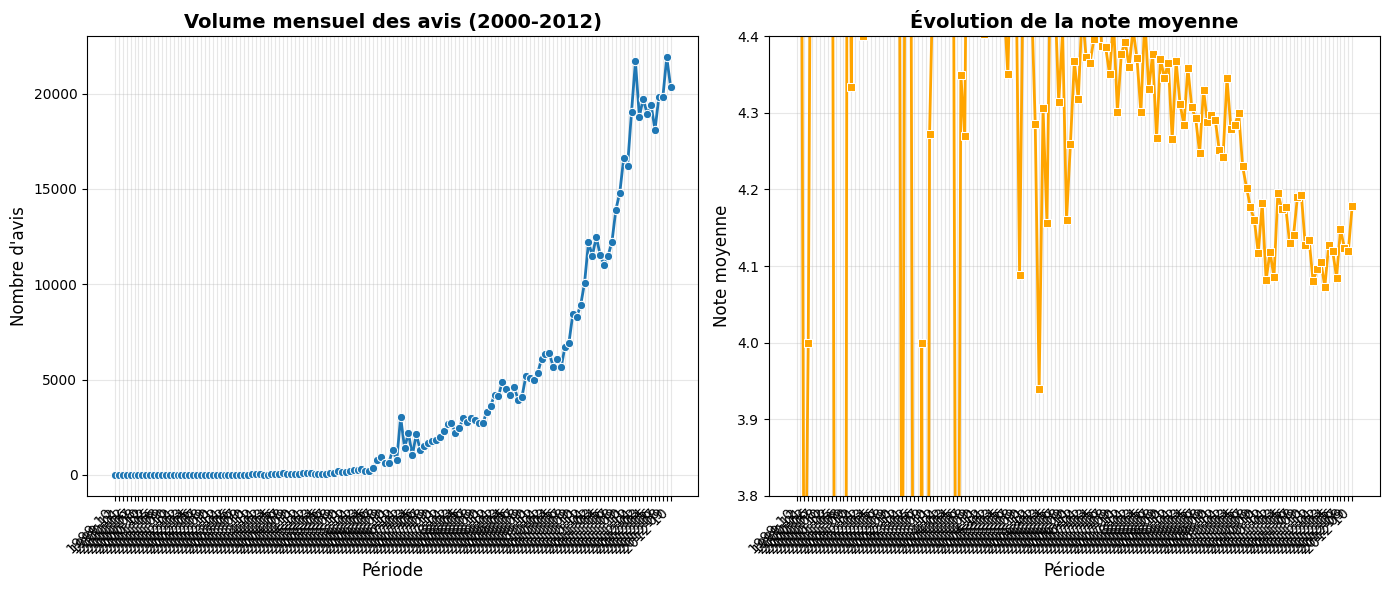


INSIGHTS TEMPOROELS
Période couverte : 1999-10 → 2012-10
Pic d'activité   : 2012-09 (21,903 avis)
Tendance notes   : 4.18 (dernier mois) vs 5.00 (premier mois)


In [13]:
# %% [markdown]
# # Analyse temporelle des avis

# %%
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Agrégats mensuels
temporal = df_clean.groupBy(
    year("ReviewDate").alias("annee"),
    month("ReviewDate").alias("mois")
).agg(
    count("*").alias("volume_mensuel"),
    avg("Score").alias("score_moyen")
).orderBy("annee", "mois")

# Conversion sécurisée vers Pandas (échantillon)
temp_pd = temporal.toPandas()
temp_pd["periode"] = temp_pd["annee"].astype(str) + "-" + temp_pd["mois"].astype(str).str.zfill(2)

# Visualisation
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.lineplot(data=temp_pd, x="periode", y="volume_mensuel", marker="o", linewidth=2, markersize=6)
plt.title("Volume mensuel des avis (2000-2012)", fontsize=14, fontweight='bold')
plt.xlabel("Période", fontsize=12)
plt.ylabel("Nombre d'avis", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
sns.lineplot(data=temp_pd, x="periode", y="score_moyen", marker="s", color='orange', linewidth=2, markersize=6)
plt.title("Évolution de la note moyenne", fontsize=14, fontweight='bold')
plt.xlabel("Période", fontsize=12)
plt.ylabel("Note moyenne", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(alpha=0.3)
plt.ylim(3.8, 4.4)

plt.tight_layout()
plt.savefig('/tmp/analyse_temporelle.png', dpi=150, bbox_inches='tight')
print("Visualisation temporelle générée")
plt.show()

# Statistiques clés
print("\n" + "="*70)
print("INSIGHTS TEMPOROELS")
print("="*70)
print(f"Période couverte : {temp_pd['periode'].min()} → {temp_pd['periode'].max()}")
print(f"Pic d'activité   : {temp_pd.loc[temp_pd['volume_mensuel'].idxmax(), 'periode']} "
      f"({temp_pd['volume_mensuel'].max():,} avis)")
print(f"Tendance notes   : {temp_pd['score_moyen'].iloc[-1]:.2f} (dernier mois) vs "
      f"{temp_pd['score_moyen'].iloc[0]:.2f} (premier mois)")

Analyse de sentiment en cours... (échantillon de 50 000 avis)

 Corrélation Score ↔ Sentiment textuel : 0.383
   (Valeurs > 0.6 indiquent un bon alignement entre note et texte)


/tmp/ipython-input-2685989524.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sentiment_by_score, x="Score", y="sentiment_moyen",


Visualisation sentiment générée


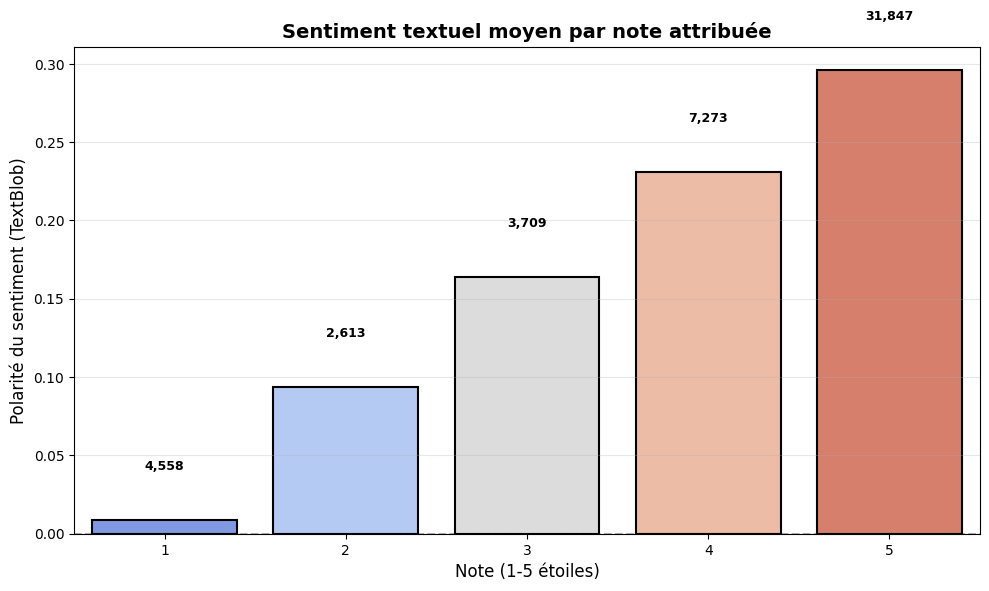


EXEMPLES D'AVIS AVEC DÉCALAGE NOTE/SENTIMENT

Exemple 1 | Note: 1 | Sentiment: 0.48
Résumé: Disappointing
Extrait: I wanted to try this in my Kcup brewer because of the positive reviews and the lower price however, I did not like the flavor of the fog chaser coffee...

Exemple 2 | Note: 1 | Sentiment: 0.36
Résumé: disappointed
Extrait: I bought this item since it has good reviews but it was not delivered as what other people described. The package was shipped by a USPS prioity envelo...

Exemple 3 | Note: 1 | Sentiment: 0.35
Résumé: Yuk!
Extrait: Tossed this out after trying it.  Texture and taste were far below expectations.  Seemed kind of mushy and pasty.  Pricy to boot....


In [14]:
# %% [markdown]
# # Analyse de sentiment textuel (TextBlob)

# %%
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
from textblob import TextBlob

print("Analyse de sentiment en cours... (échantillon de 50 000 avis)")

# UDF optimisée pour TextBlob
def analyze_sentiment(text):
    if not text or len(text.strip()) < 15:
        return 0.0
    try:
        # Limite à 300 caractères pour performance
        blob = TextBlob(text[:300])
        return float(blob.sentiment.polarity)
    except:
        return 0.0

sentiment_udf = udf(analyze_sentiment, FloatType())

# Appliquer sur échantillon représentatif
df_sample = df_clean.sample(fraction=0.09, seed=42).limit(50000)
df_sentiment = df_sample.withColumn("sentiment_score", sentiment_udf(col("Text")))

# Corrélation
correlation = df_sentiment.stat.corr("Score", "sentiment_score")
print(f"\n Corrélation Score ↔ Sentiment textuel : {correlation:.3f}")
print("   (Valeurs > 0.6 indiquent un bon alignement entre note et texte)")

# Distribution par note
sentiment_by_score = df_sentiment.groupBy("Score").agg(
    avg("sentiment_score").alias("sentiment_moyen"),
    count("*").alias("nb_avis")
).orderBy("Score").toPandas()

# Visualisation
plt.figure(figsize=(10, 6))
sns.barplot(data=sentiment_by_score, x="Score", y="sentiment_moyen",
            palette="coolwarm", edgecolor='black', linewidth=1.5)
plt.title("Sentiment textuel moyen par note attribuée", fontsize=14, fontweight='bold')
plt.xlabel("Note (1-5 étoiles)", fontsize=12)
plt.ylabel("Polarité du sentiment (TextBlob)", fontsize=12)
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
plt.grid(axis='y', alpha=0.3)

# Ajout du nombre d'avis
for idx, row in sentiment_by_score.iterrows():
    plt.text(idx, row['sentiment_moyen'] + 0.03, f"{int(row['nb_avis']):,}",
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('/tmp/sentiment_analysis.png', dpi=150, bbox_inches='tight')
print("Visualisation sentiment générée")
plt.show()

# Exemples concrets
print("\n" + "="*70)
print("EXEMPLES D'AVIS AVEC DÉCALAGE NOTE/SENTIMENT")
print("="*70)
examples = df_sentiment.filter(
    ((col("Score") == 1) & (col("sentiment_score") > 0.3)) |
    ((col("Score") == 5) & (col("sentiment_score") < -0.2))
).select("Score", "sentiment_score", "Summary", "Text").limit(3).toPandas()

for i, row in examples.iterrows():
    print(f"\nExemple {i+1} | Note: {row['Score']} | Sentiment: {row['sentiment_score']:.2f}")
    print(f"Résumé: {row['Summary']}")
    print(f"Extrait: {row['Text'][:150]}...")

In [16]:
# %% [markdown]
# # Détection d'avis suspects avec règles métier

# %%
from pyspark.sql.functions import lit, length, col, when, concat_ws, desc

# Définition des règles de détection
df_suspicious = df_clean \
    .withColumn("longueur_texte", length(col("Text"))) \
    .withColumn("avis_suspect", lit(False)) \
    .withColumn("raison_suspicion", lit("")) \
    .withColumn("avis_suspect",
        when((col("longueur_texte") < 25) & (col("Score").isin([1, 5])), True)
        .otherwise(col("avis_suspect"))
    ) \
    .withColumn("raison_suspicion",
        when((col("longueur_texte") < 25) & (col("Score").isin([1, 5])),
             concat_ws("|", col("raison_suspicion"), lit("TEXTE_TROP_COURT")))
        .otherwise(col("raison_suspicion"))
    ) \
    .withColumn("avis_suspect",
        when(col("Text").rlike("(.)\\1{15,}"), True)  # 15+ caractères identiques
        .otherwise(col("avis_suspect"))
    ) \
    .withColumn("raison_suspicion",
        when(col("Text").rlike("(.)\\1{15,}"),
             concat_ws("|", col("raison_suspicion"), lit("CARACTERES_REPETES")))
        .otherwise(col("raison_suspicion"))
    )

# Statistiques
total = df_clean.count()
suspects = df_suspicious.filter(col("avis_suspect") == True).count()
pct = suspects / total * 100

print("="*70)
print(f"DÉTECTION D'AVIS SUSPECTS : {suspects:,} avis ({pct:.2f}%)")
print("="*70)

# Top raisons
reasons = df_suspicious.filter(col("avis_suspect") == True) \
    .groupBy("raison_suspicion") \
    .count() \
    .orderBy(desc("count")) \
    .limit(5) \
    .toPandas()

print("\nTop raisons de suspicion :")
for _, row in reasons.iterrows():
    clean_reason = row['raison_suspicion'].replace("||", "|").strip("|")
    if not clean_reason:
        clean_reason = "COMBINAISON_RÈGLES"
    print(f"  • {clean_reason:30s} : {row['count']:6,} avis")

# Exemples concrets
print("\n" + "="*70)
print("EXEMPLES D'AVIS SUSPECTS")
print("="*70)
examples = df_suspicious.filter(col("avis_suspect") == True) \
    .select("Score", "ProductId", "Summary", "Text", "raison_suspicion") \
    .limit(3).toPandas()

for i, row in examples.iterrows():
    print(f"\nExemple {i+1} | Note: {row['Score']} | Produit: {row['ProductId']}")
    print(f"Raison: {row['raison_suspicion']}")
    print(f"Résumé: {row['Summary']}")
    print(f"Texte : {row['Text'][:200]}...")

DÉTECTION D'AVIS SUSPECTS : 419 avis (0.07%)

Top raisons de suspicion :
  • CARACTERES_REPETES             :    403 avis
  • TEXTE_TROP_COURT               :     16 avis

EXEMPLES D'AVIS SUSPECTS

Exemple 1 | Note: 5 | Produit: B003JSU1R2
Raison: |CARACTERES_REPETES
Résumé: Can't get any better
Texte : When I saw these in the store I got one bag.  Then I thought if these are any good at all I better get more.  So, I bought 2 bags.  In less then 24 hours both bags are empty.  They are fabulous and I'...

Exemple 2 | Note: 1 | Produit: B000H7LVKY
Raison: |CARACTERES_REPETES
Résumé: old the worse product ever
Texte : i just got it and it is old and does not worth it...the taste is not as good either i did not get it why they get so many 5 stars rating......................it is the worse product i have ever bought...

Exemple 3 | Note: 5 | Produit: B000E46LX2
Raison: |CARACTERES_REPETES
Résumé: That's what i'm talkin-bout
Texte : I made a mistake on the other review, I mixed it up with a

In [17]:
# %% [markdown]
# # Export des résultats et sauvegarde

# %%
import json
from google.colab import files

print("="*70)
print("EXPORT DES RÉSULTATS")
print("="*70)

# 1. Statistiques globales en JSON
stats_globales = {
    "total_avis_analyses": df_clean.count(),
    "total_produits": df_clean.select("ProductId").distinct().count(),
    "total_utilisateurs": df_clean.select("UserId").distinct().count(),
    "moyenne_generale": df_clean.agg(avg("Score")).first()[0],
    "avis_suspects": df_suspicious.filter(col("avis_suspect") == True).count(),
    "correlation_note_sentiment": float(f"{correlation:.3f}"),
    "periode_debut": df_clean.agg({"ReviewDate": "min"}).first()[0],
    "periode_fin": df_clean.agg({"ReviewDate": "max"}).first()[0]
}

with open('/tmp/stats_globales.json', 'w') as f:
    json.dump(stats_globales, f, indent=2, default=str)

print("Statistiques globales exportées : stats_globales.json")
print(json.dumps(stats_globales, indent=2, default=str))

# 2. Top produits en CSV
top_produits.limit(100).toPandas().to_csv('/tmp/top_produits.csv', index=False)
print("Top 100 produits exportés : top_produits.csv")

# 3. Utilisateurs suspects en CSV
super_reviewers.limit(50).toPandas().to_csv('/tmp/utilisateurs_suspects.csv', index=False)
print("Top 50 utilisateurs suspects exportés : utilisateurs_suspects.csv")

# 4. Avis suspects échantillon
df_suspicious.filter(col("avis_suspect") == True) \
    .select("ProductId", "UserId", "Score", "Summary", "Text", "raison_suspicion") \
    .limit(200).toPandas().to_csv('/tmp/avis_suspects.csv', index=False)
print("Échantillon d'avis suspects exporté : avis_suspects.csv (200 lignes)")

# Téléchargement des fichiers depuis Colab
print("\n" + "="*70)
print("TÉLÉCHARGEMENT DES RÉSULTATS")
print("="*70)
files.download('/tmp/stats_globales.json')
files.download('/tmp/top_produits.csv')
files.download('/tmp/utilisateurs_suspects.csv')
files.download('/tmp/avis_suspects.csv')
files.download('/tmp/analyse_temporelle.png')
files.download('/tmp/sentiment_analysis.png')

print("\n Tous les fichiers ont été téléchargés sur votre machine !")

EXPORT DES RÉSULTATS
Statistiques globales exportées : stats_globales.json
{
  "total_avis_analyses": 567249,
  "total_produits": 74258,
  "total_utilisateurs": 256059,
  "moyenne_generale": 4.184120201181492,
  "avis_suspects": 419,
  "correlation_note_sentiment": 0.383,
  "periode_debut": "1999-10-08 00:00:00",
  "periode_fin": "2012-10-26 00:00:00"
}
Top 100 produits exportés : top_produits.csv
Top 50 utilisateurs suspects exportés : utilisateurs_suspects.csv
Échantillon d'avis suspects exporté : avis_suspects.csv (200 lignes)

TÉLÉCHARGEMENT DES RÉSULTATS


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


 Tous les fichiers ont été téléchargés sur votre machine !
